In [1]:
import numpy as np
import regex as re
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

2023-05-31 22:58:22.130770: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 22:58:22.648417: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 22:58:22.650174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 22:58:24.940136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_pickle('./data/dataframes/outer_merged_normalized.pkl')
df.shape

(37660, 2)

In [4]:
df.drop_duplicates(inplace = True)
df.shape

(8479, 2)

In [5]:
all_categories = ['sport', 'autos', 'religion', 'comp_elec', 'sci_med', 'seller', 'politics']
# We'll use all
target_categories = ['sport', 'autos', 'religion', 'comp_elec', 'sci_med', 'seller', 'politics']

In [6]:
# container for sentences
X = np.array([subject for subject in df['subject']])
# container for sentences
y = np.array([subject for subject in df['newsgroup']])

In [7]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(df['newsgroup'])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

classes = np.unique(y_train)
mapping = dict(zip(classes, target_categories))

len(X_train), len(X_test), classes, mapping

(6359,
 2120,
 array([0, 1, 2, 3, 4, 5, 6]),
 {0: 'sport',
  1: 'autos',
  2: 'religion',
  3: 'comp_elec',
  4: 'sci_med',
  5: 'seller',
  6: 'politics'})

In [9]:
max_tokens = 50 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

## Vectorizing data to keep 50 words per sample.
X_train_vect = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_tokens, padding="post", truncating="post", value=0.)
X_test_vect  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_tokens, padding="post", truncating="post", value=0.)

print(X_train_vect[:3])

X_train_vect.shape, X_test_vect.shape

[[ 403  190 1585    4 5718    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  40 1931    4    2  305  783    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  40  245   84   58    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]


((6359, 50), (2120, 50))

In [10]:
print("Vocab Size : {}".format(len(tokenizer.word_index)))

Vocab Size : 9734


In [11]:
path = './glove.6B.50d.txt'
glove_embeddings = {}
with open(path) as f:
    for line in f:
        try:
            line = line.split()
            glove_embeddings[line[0]] = np.array(line[1:], dtype=np.float32)
        except:
            continue

In [12]:
embed_len = 50

word_embeddings = np.zeros((len(tokenizer.index_word)+1, embed_len))

for idx, word in tokenizer.index_word.items():
    word_embeddings[idx] = glove_embeddings.get(word, np.zeros(embed_len))

In [13]:
word_embeddings[1][:10]

array([ 0.15272   ,  0.36181   , -0.22168   ,  0.066051  ,  0.13029   ,
        0.37075001, -0.75874001, -0.44722   ,  0.22563   ,  0.10208   ])

### Approach 1: GloVe Embeddings Flattened (Max Tokens=50, Embedding Length=300) 

In [14]:
model = Sequential([
                    Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=embed_len,
                              input_length=max_tokens, trainable=False, weights=[word_embeddings]),
                    Flatten(),
                    Dense(128, activation="relu"),
                    Dense(64, activation="relu"),
                    Dense(len(target_categories), activation="softmax")
                ])
model._name = "SparseCategoricalEntireData"
model.summary()

Model: "SparseCategoricalEntireData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            486750    
                                                                 
 flatten (Flatten)           (None, 2500)              0         
                                                                 
 dense (Dense)               (None, 128)               320128    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 815,589
Trainable params: 328,839
Non-trainable params: 486,750
_________________________________________________________________


In [15]:
model.weights[0][1][:10], word_embeddings[1][:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([ 0.15272 ,  0.36181 , -0.22168 ,  0.066051,  0.13029 ,  0.37075 ,
        -0.75874 , -0.44722 ,  0.22563 ,  0.10208 ], dtype=float32)>,
 array([ 0.15272   ,  0.36181   , -0.22168   ,  0.066051  ,  0.13029   ,
         0.37075001, -0.75874001, -0.44722   ,  0.22563   ,  0.10208   ]))

In [16]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [17]:
model.fit(X_train_vect, y_train, batch_size=32, epochs=8, validation_data=(X_test_vect, y_test))

Epoch 1/8
199/199 [==============================] - 2s 7ms/step - loss: 1.0914 - accuracy: 0.6204 - val_loss: 0.8999 - val_accuracy: 0.6991
Epoch 2/8
199/199 [==============================] - 1s 7ms/step - loss: 0.7200 - accuracy: 0.7523 - val_loss: 0.8842 - val_accuracy: 0.7005
Epoch 3/8
199/199 [==============================] - 1s 6ms/step - loss: 0.5846 - accuracy: 0.8039 - val_loss: 0.9162 - val_accuracy: 0.6943
Epoch 4/8
199/199 [==============================] - 1s 6ms/step - loss: 0.4762 - accuracy: 0.8413 - val_loss: 0.9271 - val_accuracy: 0.7113
Epoch 5/8
199/199 [==============================] - 1s 6ms/step - loss: 0.3774 - accuracy: 0.8777 - val_loss: 0.9703 - val_accuracy: 0.7014
Epoch 6/8
199/199 [==============================] - 1s 7ms/step - loss: 0.2971 - accuracy: 0.9093 - val_loss: 1.0452 - val_accuracy: 0.7033
Epoch 7/8
199/199 [==============================] - 1s 6ms/step - loss: 0.2273 - accuracy: 0.9338 - val_loss: 1.1258 - val_accuracy: 0.7014
Epoch 8/8
199

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_preds = model.predict(X_test_vect).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(y_test, y_preds)))
print("\nClassification Report : ")
print(classification_report(y_test, y_preds, target_names=target_categories))
print("\nConfusion Matrix : ")
print(confusion_matrix(y_test, y_preds))

67/67 [==============================] - 0s 2ms/step
Test Accuracy : 0.6943396226415094

Classification Report : 
              precision    recall  f1-score   support

       sport       0.54      0.49      0.51       189
       autos       0.77      0.84      0.80       901
    religion       0.60      0.62      0.61       220
   comp_elec       0.66      0.56      0.61       179
     sci_med       0.65      0.47      0.55       192
      seller       0.59      0.58      0.59       221
    politics       0.72      0.78      0.75       218

    accuracy                           0.69      2120
   macro avg       0.65      0.62      0.63      2120
weighted avg       0.69      0.69      0.69      2120


Confusion Matrix : 
[[ 92  42   9   5   7  27   7]
 [ 37 755  28   8  14  46  13]
 [ 10  22 137  21  10   4  16]
 [  3  25  30 101   8   1  11]
 [  8  59  12  11  90   5   7]
 [ 12  59   3   0   8 128  11]
 [  8  18   9   8   1   5 169]]


In [21]:
# TensorFlow SavedModel format => .keras
model_file = 'models/sparse_cat_entire'
model.save(model_file)

INFO:tensorflow:Assets written to: models/sparse_cat_entire/assets


INFO:tensorflow:Assets written to: models/sparse_cat_entire/assets


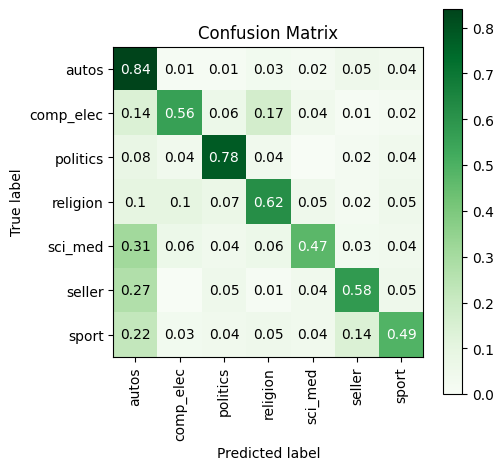

In [23]:
!pip install scikit-plot
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

skplt.metrics.plot_confusion_matrix([target_categories[i] for i in y_test], [target_categories[i] for i in y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Greens",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

### Custom Test

In [24]:
# define documents
docs = ['Democrats the Reuplicans are both the worst!',
'Coyotes win 10-0',
'Houston Astros defeat the Cubs',
'Apple and Microsoft both make great computers',
'New washer 4sale. $200']

doc_array = np.array(docs)

doc_array_vect  = pad_sequences(tokenizer.texts_to_sequences(doc_array), maxlen=max_tokens, padding="post", truncating="post", value=0.)

cstm_test_preds = model.predict(doc_array_vect).argmax(axis=-1)

1/1 [==============================] - 0s 20ms/step


In [25]:
print(doc_array)

['Democrats the Reuplicans are both the worst!' 'Coyotes win 10-0'
 'Houston Astros defeat the Cubs'
 'Apple and Microsoft both make great computers' 'New washer 4sale. $200']


In [26]:
print(doc_array_vect)

[[   2   53 3716    2 1299    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  69  199   47    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [2931 4257    2 1113    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [ 124    3  461 3716  277  580 1149    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 

In [27]:
print(cstm_test_preds)

[6 6 6 1 5]
